# Whittle likelihood 

Needs:
  - Periodogram
  - analytical spectral model
  
 

In [1]:
from gptide import cov
from gptide import GPtideScipy, GPtideToeplitz
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az

from scipy import stats, signal
from gptide import stats as gpstats

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Test Sykulski 2016 PSD<-->ACF

$$
S(\omega;\theta) = \frac{\eta^2}{(\omega-\omega_0)^2+\lambda^2}
$$

$$
C(t;\theta) = \frac{\eta^2}{2\lambda}\exp\left( -|t|\lambda\right)\cos(\omega_0 t)
$$

$\theta=\lbrace\eta, \lambda, \omega_0\rbrace$

In [2]:
# %matplotlib notebook

In [413]:
def cov_lorentzian(x, xpr, params):
    eta, lambda_t, l_t = params
        
    return eta**2 * cov.matern12(x, xpr, lambda_t) * cov.cosine(x, xpr, l_t)



Text(0.5, 0, 'x')

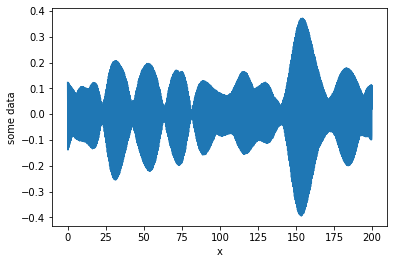

In [414]:
####
# These are our kernel input parameters
noise = 0.001
η = 0.1
λ_t = 100.
ℓ_t = 0.5
covfunc = cov_lorentzian
###
# Domain size parameters
dx = 0.1
N = 2000
covparams = (η, λ_t, ℓ_t)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]


GP = GPtideScipy(xd, xd, noise, covfunc, covparams)

# Use the .prior() method to obtain some samples
yd = GP.prior(samples=1)

plt.figure()
plt.plot(xd, yd,)
plt.ylabel('some data')
plt.xlabel('x')

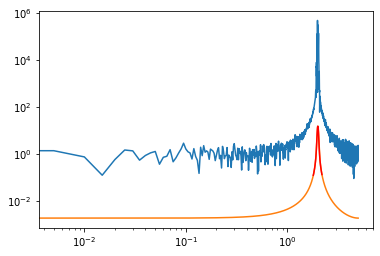

In [415]:
def myperiodogram(y, dx, window=np.hanning):
    M=y.shape[0]
    win = window(M)
    scale = 1.0 / (dx * (win*win).sum())
    y_hat = np.fft.fft(y*win)
    S = dx*np.abs(y_hat)**2
    omega = np.fft.fftfreq(int(M),d=dx)
    
    return omega[:M//2], S[:M//2]

def myperiodogram(y, dx):
    M=y.shape[0]
    y_hat = np.fft.fft(y)
    S = np.abs(y_hat)**2 
    omega = np.fft.fftfreq(int(M),d=dx)
    
    return omega[:M//2], S[:M//2]

C = covfunc(xd, xd[0], (η, λ_t, ℓ_t))[:,0]

omega, Sparam = myperiodogram(C, dx)

omega, S_z = myperiodogram(yd[:,0], dx)

# Scale
# Sparam *= N*dx/η**2
# S_z *= 1/dx
# Sparam *= dx
S_z /= np.var(yd)
Sparam /= np.var(yd)
# _, S = signal.periodogram(C.ravel()*N/(2*np.pi), 1/dx, scaling='density')

idx = (omega>0.9*(1/ℓ_t)) & (omega<1.1*(1/ℓ_t))
plt.figure()
plt.loglog(omega, S_z)
plt.loglog(omega, Sparam)
plt.loglog(omega[idx], Sparam[idx],'r')

In [416]:
ratio = S_z[idx]/Sparam[idx]
ratio.mean(), np.var(yd), N*dx

(2783.936423203319, 0.0131633571954809, 200.0)

PSD ratio:  8439.07044725096


(1, 3)

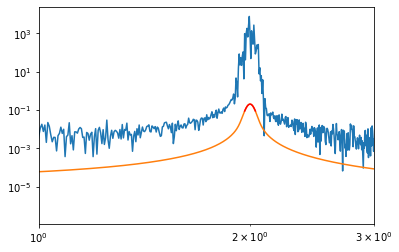

In [596]:
def myperiodogram(y, dx, scale=1):
    M=y.shape[0]
    y_hat = np.fft.fft(y)
    S = np.abs(y_hat)**2 
    omega = np.fft.fftfreq(int(M),d=dx)

    return omega[:M//2], scale*S[:M//2]

def compare_acf_psd(noise, η, λ_t, ℓ_t, dx, N, covfunc = cov_lorentzian):

    covparams = (η, λ_t, ℓ_t)

    # Input data points
    xd = np.arange(0,dx*N,dx)[:,None]


    GP = GPtideScipy(xd, xd, noise, covfunc, covparams)

    # Use the .prior() method to obtain some samples
    yd = GP.prior(samples=1)
    
    C = covfunc(xd, xd[0], (η, λ_t, ℓ_t))[:,0]
    
    acf = C#/C[0]

    omega, Sparam = myperiodogram(acf, dx, scale=1)
    #Sparam = np.fft.fft(acf).real[:N//2]
    omega, S_z = myperiodogram(yd[:,0], dx, scale=1)
    
    #omega, Sparam = signal.periodogram(C, dx)
    #omega, S_z = signal.periodogram(yd[:,0], dx)
    
    # Scaling
    #Sparam *= C[0]*N*dx
    #S_z /= yd.var()
    
    idx = (omega>0.98*(1/ℓ_t)) & (omega<1.02*(1/ℓ_t))
    ratio = S_z[idx]/Sparam[idx]
    print('PSD ratio: ',ratio.mean())
    
    
    plt.figure()
    plt.loglog(omega, S_z)
    plt.loglog(omega, Sparam)
    plt.loglog(omega[idx], Sparam[idx],'r')
    
compare_acf_psd(noise, η, λ_t, ℓ_t, dx, N)
plt.xlim(1, 3)

PSD ratio:  256.37443508486


(1, 3)

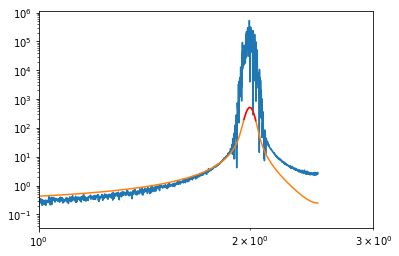

In [597]:
compare_acf_psd(noise, η*10, λ_t, ℓ_t, dx*2, N*2)
plt.xlim(1, 3)

In [515]:
def whittle_likelihood(omega, S, specfunc, params):
    S_param = specfunc(omega, params)
    return -np.sum(S/S_param + np.log(S_param) )

def whittle_likelihood_acf(x, yd, covfunc, params):
    C = covfunc(xd, xd[0], params)[:,0]
    N = xd.shape[0]
    dx = xd[1]-xd[0]
    omega, S_param = myperiodogram(C/C[0], dx)
    omega, S = myperiodogram(yd[:,0], dx)
    #omega, S_param = myperiodogram(C*np.sqrt(N*2*np.pi), dx)

    return -np.sum(S/S_param + np.log(S_param) )

In [484]:
print(whittle_likelihood_acf(xd, yd, cov_lorentzian, (η, λ_t, ℓ_t)))
print(whittle_likelihood_acf(xd, yd, cov_lorentzian, (η*4, λ_t, ℓ_t)))


-72.41479560186156
-2777.1146469648975
